In [1]:
import pandas as pd

yaztargets = pd.read_csv("https://raw.githubusercontent.com/opimwue/ddop/master/ddop/datasets/data/yaz_target.csv")
yazdata = pd.read_csv("https://raw.githubusercontent.com/opimwue/ddop/master/ddop/datasets/data/yaz_data.csv")
yaz_simple = pd.DataFrame({'date':yazdata['date'], 'demand':yaztargets['steak']})
yaz_simple['date'] = pd.to_datetime(yaz_simple['date'])


In [2]:
yaz_simple

,date,demand
0,2013-10-04,36
1,2013-10-05,30
2,2013-10-06,16
3,2013-10-07,22
4,2013-10-08,29
...,...,...
760,2015-11-03,32
761,2015-11-04,38
762,2015-11-05,24
763,2015-11-06,32


In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
y = yaz_simple['demand']
X = pd.DataFrame({'timeStep' : list(yaz_simple.index)})

In [5]:
linReg = LinearRegression()

In [6]:
linReg.fit(X,y)

LinearRegression()

In [7]:
linReg.coef_

array([-0.00996882])

In [8]:
linReg.intercept_

26.14142220857011

<Axes: xlabel='date', ylabel='demand'>

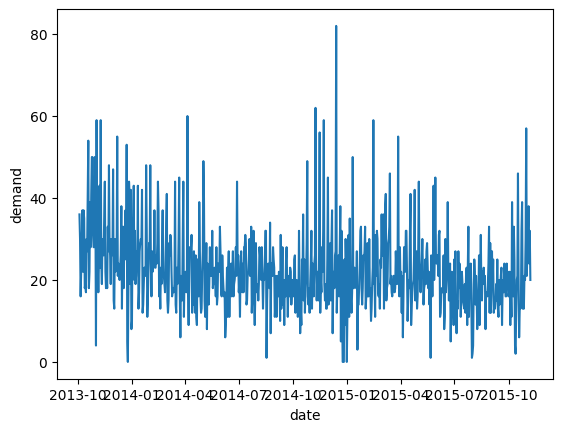

In [9]:
import seaborn as sns

sns.lineplot(x='date', y='demand', data = yaz_simple)

In [10]:
X['timeStep']*linReg.coef_[0]

0     -0.000000
1     -0.009969
2     -0.019938
3     -0.029906
4     -0.039875
         ...   
760   -7.576302
761   -7.586271
762   -7.596240
763   -7.606209
764   -7.616178
Name: timeStep, Length: 765, dtype: float64

In [11]:
yaz_simple['demand_detrended'] = yaz_simple['demand'] - X['timeStep']*linReg.coef_[0]

In [12]:
yaz_simple[['demand_detrended','demand']]

,demand_detrended,demand
0,36.000000,36
1,30.009969,30
2,16.019938,16
3,22.029906,22
4,29.039875,29
...,...,...
760,39.576302,32
761,45.586271,38
762,31.596240,24
763,39.606209,32


<Axes: xlabel='date', ylabel='demand_detrended'>

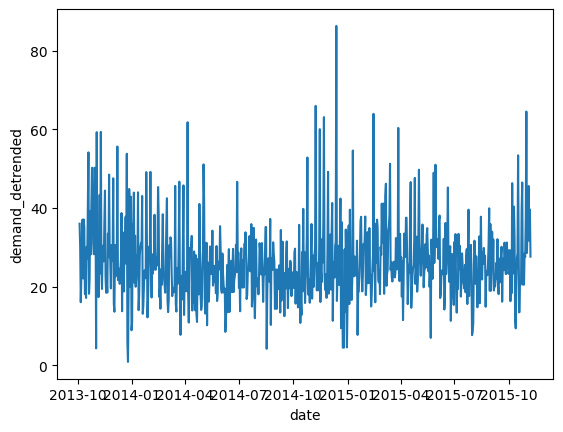

In [13]:
sns.lineplot(x='date', y='demand_detrended', data = yaz_simple)

In [14]:
yaz_simple['weekday'] = yaz_simple['date'].dt.day_name()

In [15]:
averageDemand = yaz_simple['demand_detrended'].mean()

In [16]:
averageDemand

26.141422208570113

In [17]:
seasonalFactors = yaz_simple.groupby('weekday')['demand_detrended'].mean() / averageDemand

In [21]:
seasonalFactors=seasonalFactors.reset_index(name="seasonalFactor")

In [22]:
seasonalFactors

,weekday,seasonalFactor
0,Friday,1.096602
1,Monday,0.842276
2,Saturday,1.492385
3,Sunday,0.761177
4,Thursday,0.940282
5,Tuesday,0.901617
6,Wednesday,0.960256


In [24]:
yaz_simple = pd.merge(yaz_simple,seasonalFactors,how="left",left_on="weekday",right_on="weekday")

In [26]:
yaz_simple['timestep'] = yaz_simple.index

In [27]:
yaz_simple

,date,demand,demand_detrended,weekday,seasonalFactor,timestep
0,2013-10-04,36,36.000000,Friday,1.096602,0
1,2013-10-05,30,30.009969,Saturday,1.492385,1
2,2013-10-06,16,16.019938,Sunday,0.761177,2
3,2013-10-07,22,22.029906,Monday,0.842276,3
4,2013-10-08,29,29.039875,Tuesday,0.901617,4
...,...,...,...,...,...,...
760,2015-11-03,32,39.576302,Tuesday,0.901617,760
761,2015-11-04,38,45.586271,Wednesday,0.960256,761
762,2015-11-05,24,31.596240,Thursday,0.940282,762
763,2015-11-06,32,39.606209,Friday,1.096602,763


In [49]:
yaz_simple['forecast'] = yaz_simple['timestep']*linReg.coef_[0] + yaz_simple.iloc()[0]['demand']
yaz_simple['forecast'] = yaz_simple['forecast']*yaz_simple['seasonalFactor']
yaz_simple

,date,demand,demand_detrended,weekday,seasonalFactor,timestep,forecast
0,2013-10-04,36,36.000000,Friday,1.096602,0,39.477679
1,2013-10-05,30,30.009969,Saturday,1.492385,1,53.710992
2,2013-10-06,16,16.019938,Sunday,0.761177,2,27.387187
3,2013-10-07,22,22.029906,Monday,0.842276,3,30.296762
4,2013-10-08,29,29.039875,Tuesday,0.901617,4,32.422268
...,...,...,...,...,...,...,...
760,2015-11-03,32,39.576302,Tuesday,0.901617,760,25.627296
761,2015-11-04,38,45.586271,Wednesday,0.960256,761,27.284458
762,2015-11-05,24,31.596240,Thursday,0.940282,762,26.707556
763,2015-11-06,32,39.606209,Friday,1.096602,763,31.136693


/home/codespace/.python/current/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='demand'>)

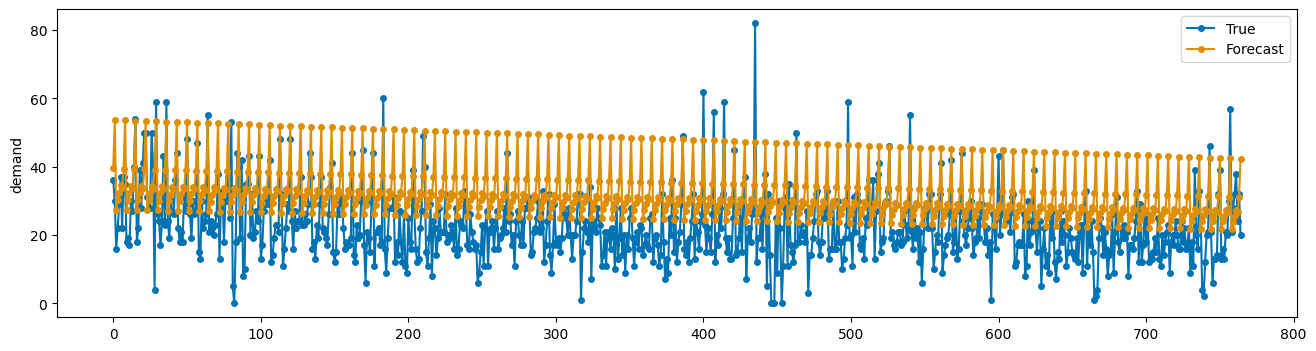

In [51]:
from sktime.utils.plotting import plot_series
plot_series(yaz_simple['demand'],yaz_simple['forecast'],labels=['True','Forecast'])